In [2]:
import tensorflow as tf
from keras import backend as K
import os
import pandas as pd
import cv2 as cv
import numpy as np
import sys
sys.path.insert(0, "../")
from deeparuco.impl.utils import IoU, match_rois
from tensorflow.keras.models import load_model
from ultralytics import YOLO
import matplotlib.pyplot as plt
import csv
import time
import json
from shapely.geometry import Polygon

2024-10-23 12:52:04.352064: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 12:52:04.466448: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 12:52:04.502230: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 12:52:04.724371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-23 12:52:06.212378: W tensorflow/compiler/tf2

WARNING ⚠️ Python>=3.10 is required, but Python==3.9.5 is currently installed 


In [3]:
model = YOLO('../models/nested_detector/best.pt')

One image


0: 512x640 3 markers, 27.8ms
Speed: 7.1ms preprocess, 27.8ms inference, 1.9ms postprocess per image at shape (1, 3, 512, 640)


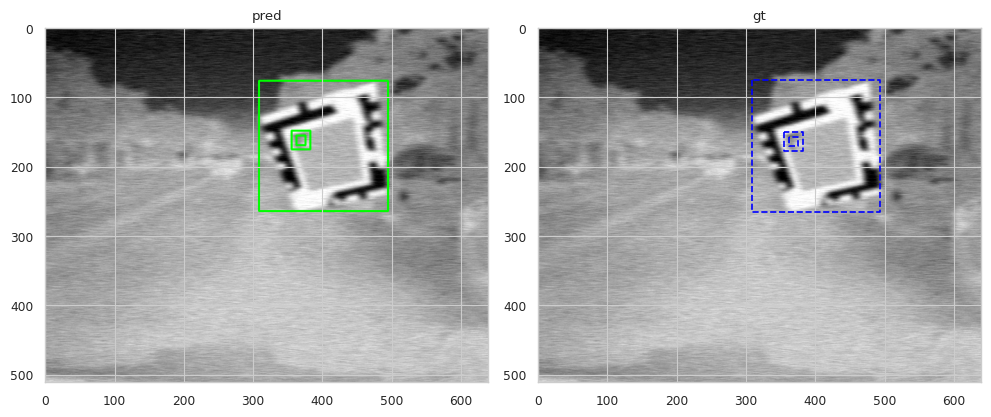

In [55]:
csv_path   = '../dataset/nested/crops/test128.csv'
df = pd.read_csv(csv_path)
row = df.iloc[100]
im_name = row.iloc[0].split('_')[0]

im_path    = "../dataset/nested/images/test/" + im_name + '.jpg'
lable_path = "../dataset/nested/labels/test/" + im_name + '.json'

with open(lable_path, 'r') as l:
    data = json.load(l)

im = cv.imread(im_path)
im_gt = cv.imread(im_path)
# bbox_gt = data['bbox_corners']


results = model(im)[0]
for result in results.boxes.data.tolist():
    x1, y1, x2, y2, score, class_id = result   
    cv.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

# To display the image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(im)

plt.title('pred')


plt.subplot(1, 2, 2)
plt.imshow(im_gt)
for marker in data:
    plt.plot(*np.append(marker["bbox_corners"], [marker["bbox_corners"][0]], axis=0).T, 'b--', label='Bounding Box')
plt.title('gt')

plt.tight_layout()
plt.show()

Multiple images

In [4]:
def calculate_iou(boxA, boxB):    
    polyA = Polygon(boxA)
    polyB = Polygon(boxB)
    
    if not polyA.is_valid or not polyB.is_valid:
        return 0.0
    
    intersection_area = polyA.intersection(polyB).area
    union_area = polyA.union(polyB).area
    
    return intersection_area / union_area if union_area > 0 else 0.0


In [36]:
eval_path = '../dataset/nested/detect_eval_model.csv'
im_dir = '../dataset/nested/images/test'
start_time = time.time()

with open(eval_path, 'a', newline='') as eval_file:
	csv_writer = csv.writer(eval_file)
	csv_writer.writerow(['image', 'id', 'reflection', 'marker_size', 'TP', 'FP', 'FN'])
	

	for im_name in os.listdir(im_dir):	# Read image and lable
		im_path = os.path.join(im_dir, im_name)
		label_path = "../dataset/nested/labels/test/"
		name = im_name.split('.')[0]
		label_path = label_path + name + '.json'
		with open(label_path, 'r') as l:
			data = json.load(l)
		im = cv.imread(im_path)
		num_markers = len(data)
		IDs = []
		bboxes = []
		reflections = []
		sizes = []
		for marker in data:
			IDs.append(marker['tag_id'])
			bbox = marker['bbox_corners']
			bbox = [(bbox[0][0], bbox[0][1]), (bbox[1][0], bbox[1][1]), (bbox[2][0], bbox[2][1]), (bbox[3][0], bbox[3][1])]
			bboxes.append(bbox)
			reflections.append(marker['reflection_area'])
			sizes.append(bbox[2][0]-bbox[0][0])
		# Predict bbox
		results = model(im)[0]

		TPs = 0
		FPs = 0
		FNs = 0
		matched_gt = []
		FP_size = []
		best_match = None
		for result in results.boxes.data.tolist():
			x1, y1, x2, y2, score, class_id = result
			pred_bbox = [(x1, y1), (x2, y1), (x2, y2), (x1, y2)]

			for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
				# print(id, IDs)
				best_iou = 0
				best_match = None

				iou = calculate_iou(pred_bbox, gt_bbox)
				if iou > best_iou and iou >= 0.5:
					best_iou = iou
					best_match = id
		
			if best_match is not None and best_match not in matched_gt:
				TPs += 1
				matched_gt.append(best_match)
				FP_size.append('NONE')
			else:
				FPs += 1
				matched_gt.append('NONE')
				FP_size.append(x2-x1)
		
		FNs = len(bboxes) - len(matched_gt)
		
		for i, matched in enumerate(matched_gt):
			# False positives
			if matched == 'NONE':
				marker_name = name
				matched_reflection = 'NONE'
				matched_size = FP_size[i]
				csv_writer.writerow([marker_name, matched, matched_reflection, matched_size, 0, 1, 0])

			# True positives
			else:
				idx = IDs.index(matched)
				marker_name = f"{name}_{matched}"
				matched_reflection = reflections[idx]
				matched_size = sizes[idx]
				csv_writer.writerow([marker_name, matched, matched_reflection, matched_size, 1, 0, 0])
				del bboxes[idx]
				del IDs[idx]
				del reflections[idx]
				del sizes[idx]
		# False negatives
		for i, (gt_bbox, id, reflection, size) in enumerate(zip(bboxes, IDs, reflections, sizes)):
			marker_name = f"{name}_{id}"
			csv_writer.writerow([marker_name, id,reflection, size, 0, 0, 1])
			
				

end_time = time.time()


0: 480x640 7 markers, 29.9ms
Speed: 12.5ms preprocess, 29.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

0: 448x640 8 markers, 25.9ms
Speed: 1.8ms preprocess, 25.9ms inference, 1.1ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 9 markers, 28.2ms
Speed: 1.4ms preprocess, 28.2ms inference, 1.1ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 2 markers, 26.5ms
Speed: 1.8ms preprocess, 26.5ms inference, 1.6ms postprocess per image at shape (1, 3, 448, 640)

0: 512x640 3 markers, 28.9ms
Speed: 1.3ms preprocess, 28.9ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 6 markers, 27.0ms
Speed: 1.7ms preprocess, 27.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 8 markers, 28.3ms
Speed: 1.6ms preprocess, 28.3ms inference, 2.0ms postprocess per image at shape (1, 3, 512, 640)

0: 512x640 2 markers, 23.4ms
Speed: 1.7ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

csv_path_model = '../dataset/nested/detect_eval_model.csv'

dfm = pd.read_csv(csv_path_model)

max_size = dfm['marker_size'].max()
print(max_size)

bins = np.arange(0, max_size + 2, 2)
dfm['size_bin'] = pd.cut(dfm['marker_size'], bins=bins, include_lowest=True, right=False)
agg_dfm = dfm.groupby('size_bin').sum().reset_index()
agg_dfm['TP'] = agg_dfm['TP']
agg_dfm['FP'] = agg_dfm['FP']
agg_dfm['FN'] = agg_dfm['FN']
agg_dfm['TP'].fillna(0, inplace=True)
agg_dfm['FP'].fillna(0, inplace=True)
agg_dfm['FN'].fillna(0, inplace=True)

bin_midpoints = [(interval.left + interval.right) / 2 for interval in agg_dfm['size_bin']]

agg_dfm_TP = list(agg_dfm['TP'])  
agg_dfm_FP = list(agg_dfm['FP'])
agg_dfm_FN = list(agg_dfm['FN'])  

756.9212770462036


/tmp/ipykernel_6258/3293728444.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg_dfm = dfm.groupby('size_bin').sum().reset_index()
/tmp/ipykernel_6258/3293728444.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  agg_dfm['TP'].fillna(0, inplace=True)
/tmp/ipykernel_6258/3293728444.py:19: FutureWarning: A value is trying to be set

In [17]:
total_tpm = dfm['TP'].sum()
total_fpm = dfm['FP'].sum()
total_fnm = dfm['FN'].sum()
precision_m = total_tpm / (total_tpm + total_fpm)
recall_m = total_tpm / (total_tpm + total_fnm)

print('model')
print(f'Total True Positives (TP): {total_tpm}')
print(f'Total False Positives (FP): {total_fpm}')
print(f'Total False Negatives (FN): {total_fnm}')
print(f'Total precision: {precision_m}')
print(f'Total recall: {recall_m}')

model
Total True Positives (TP): 2893
Total False Positives (FP): 14873
Total False Negatives (FN): 13779
Total precision: 0.1628391309242373
Total recall: 0.17352447216890596


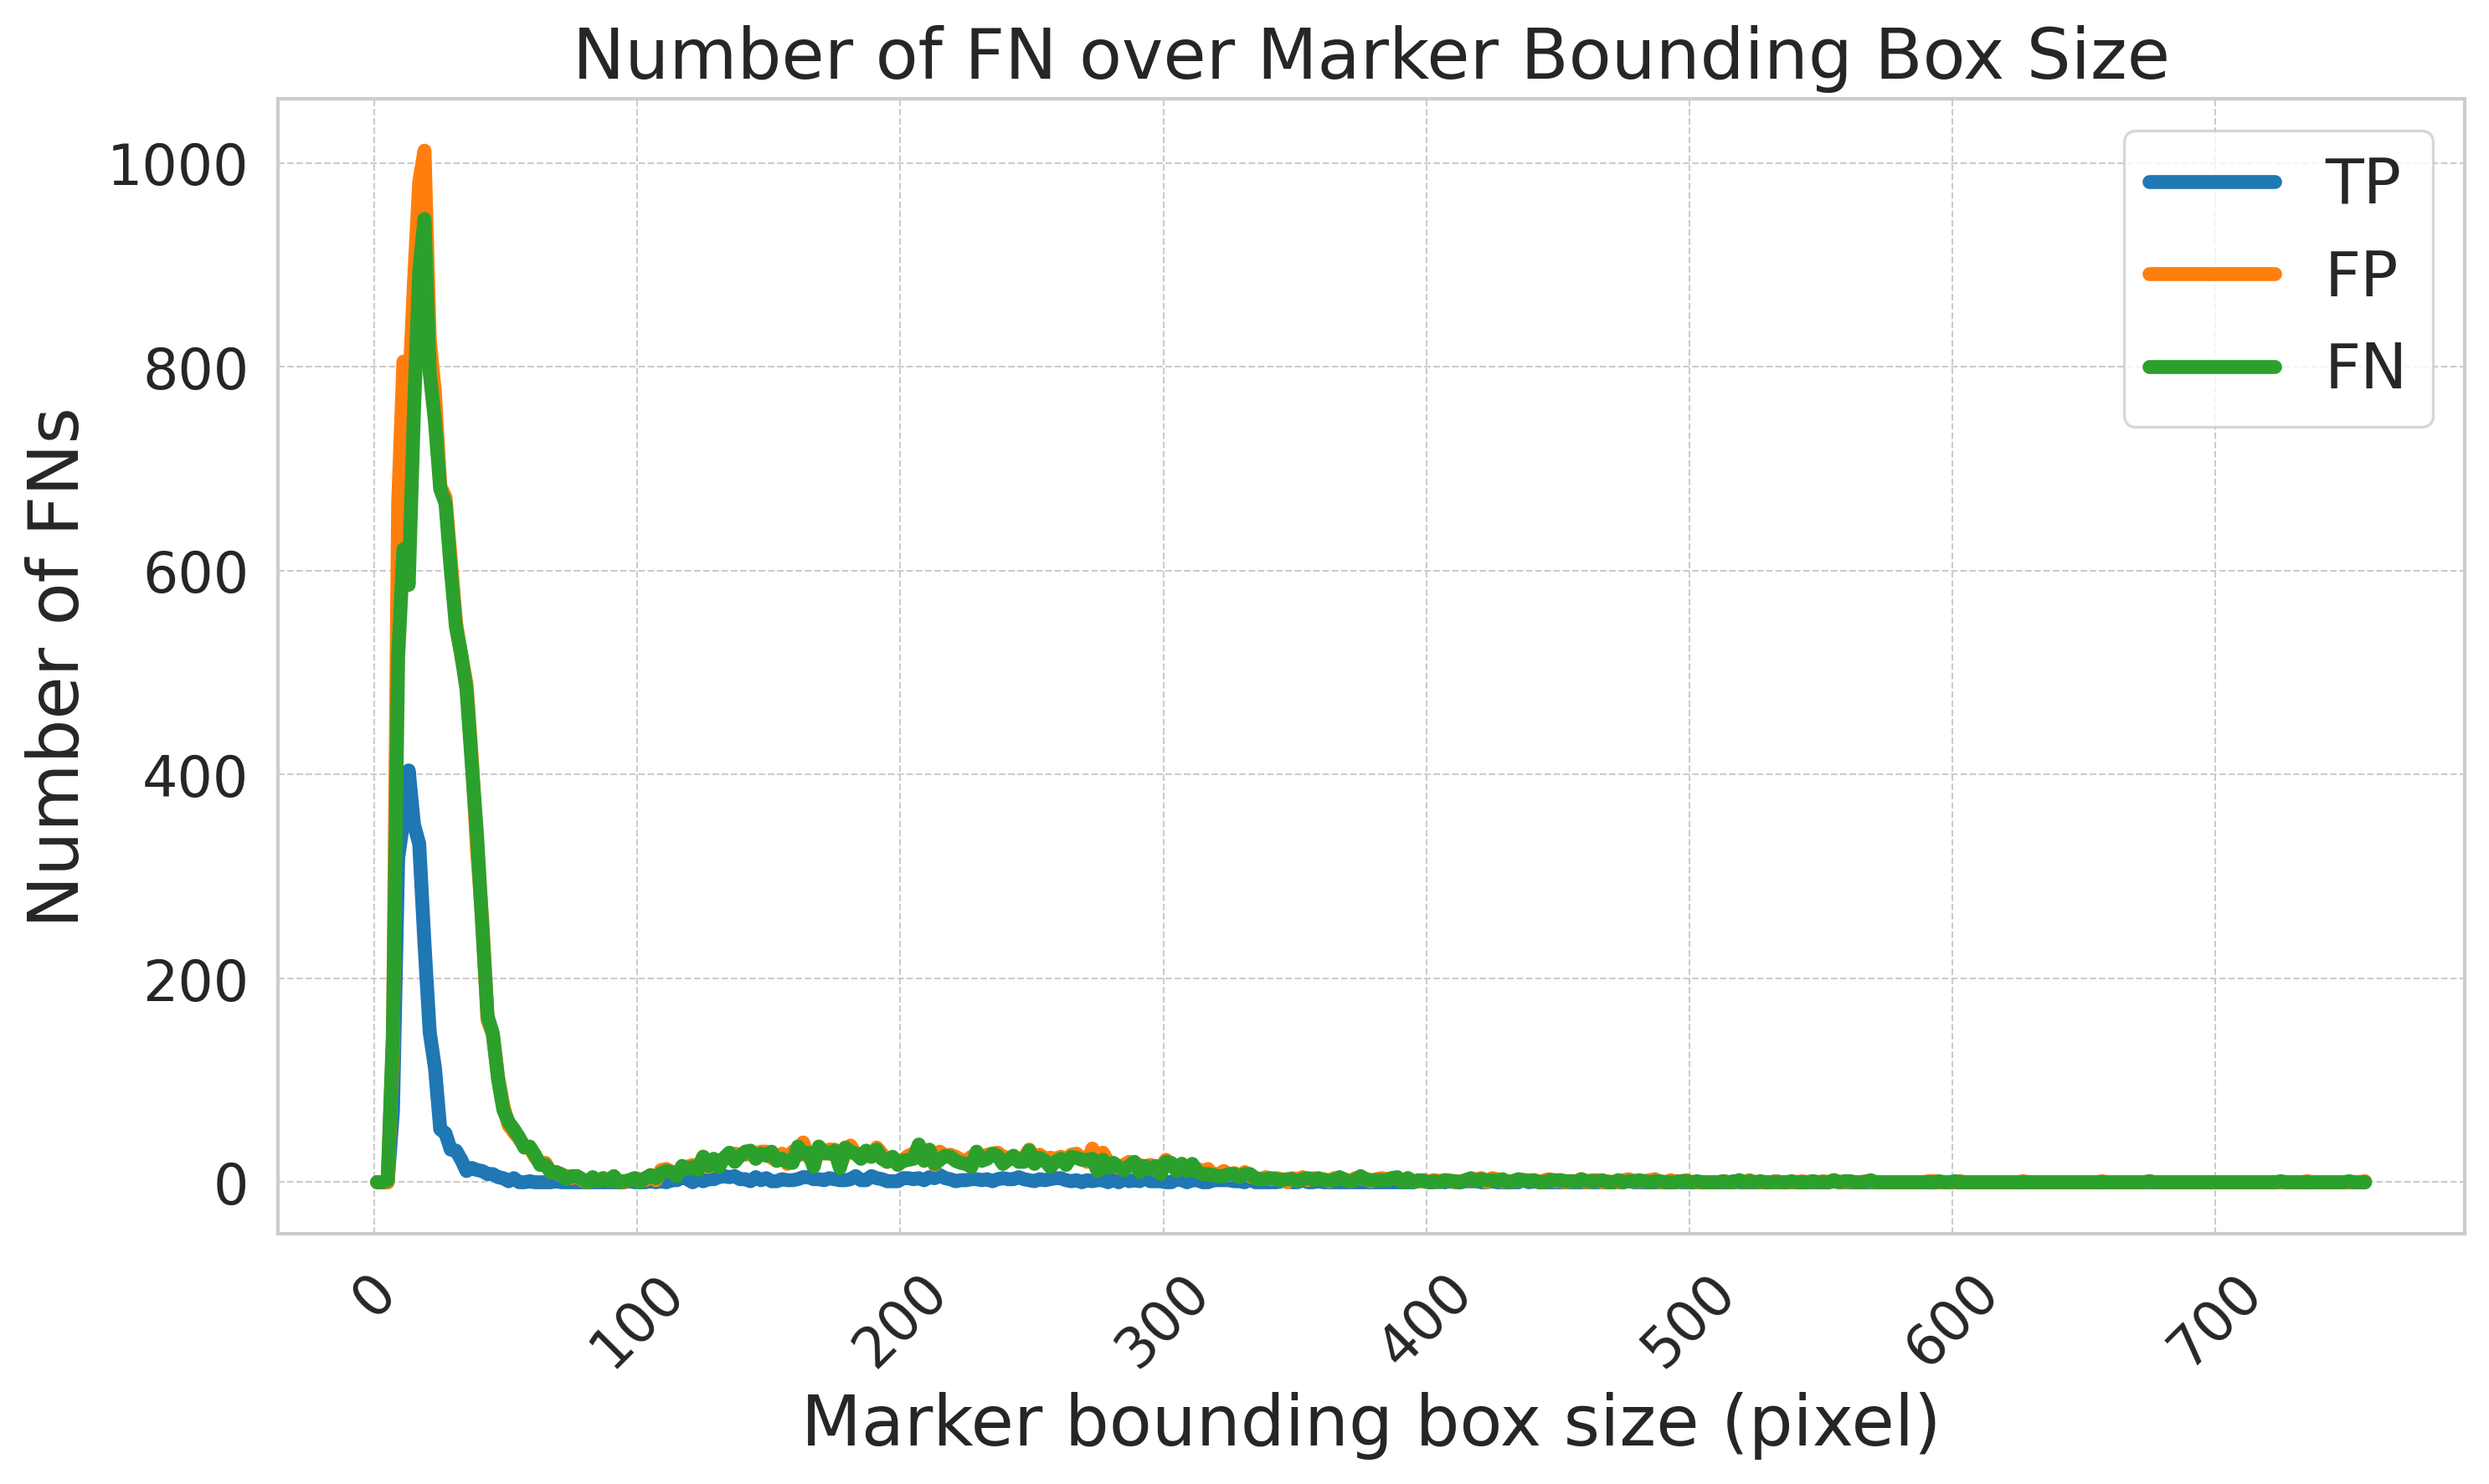

In [45]:
import seaborn as sns

sns.set_context("paper") 
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality

plt.plot(bin_midpoints, agg_dfm_TP, label='TP', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_FP, label='FP', linestyle='-', linewidth=4, markersize=8)
plt.plot(bin_midpoints, agg_dfm_FN, label='FN', linestyle='-', linewidth=4, markersize=8)


# Label the axes with larger font size
plt.xlabel('Marker bounding box size (pixel)', fontsize=20)
plt.ylabel('Number of FNs', fontsize=20)

# Add a title with a larger font size
plt.title('Number of FN over Marker Bounding Box Size', fontsize=20)

# Customize the legend
plt.legend(fontsize=18, loc='upper right', frameon=True)

# Increase the tick size and rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)

# Remove unnecessary grid lines (optional)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Save the plot as a high-resolution image if needed for publication
plt.tight_layout()  # This ensures everything fits well into the figure
# Show the plot
plt.show()


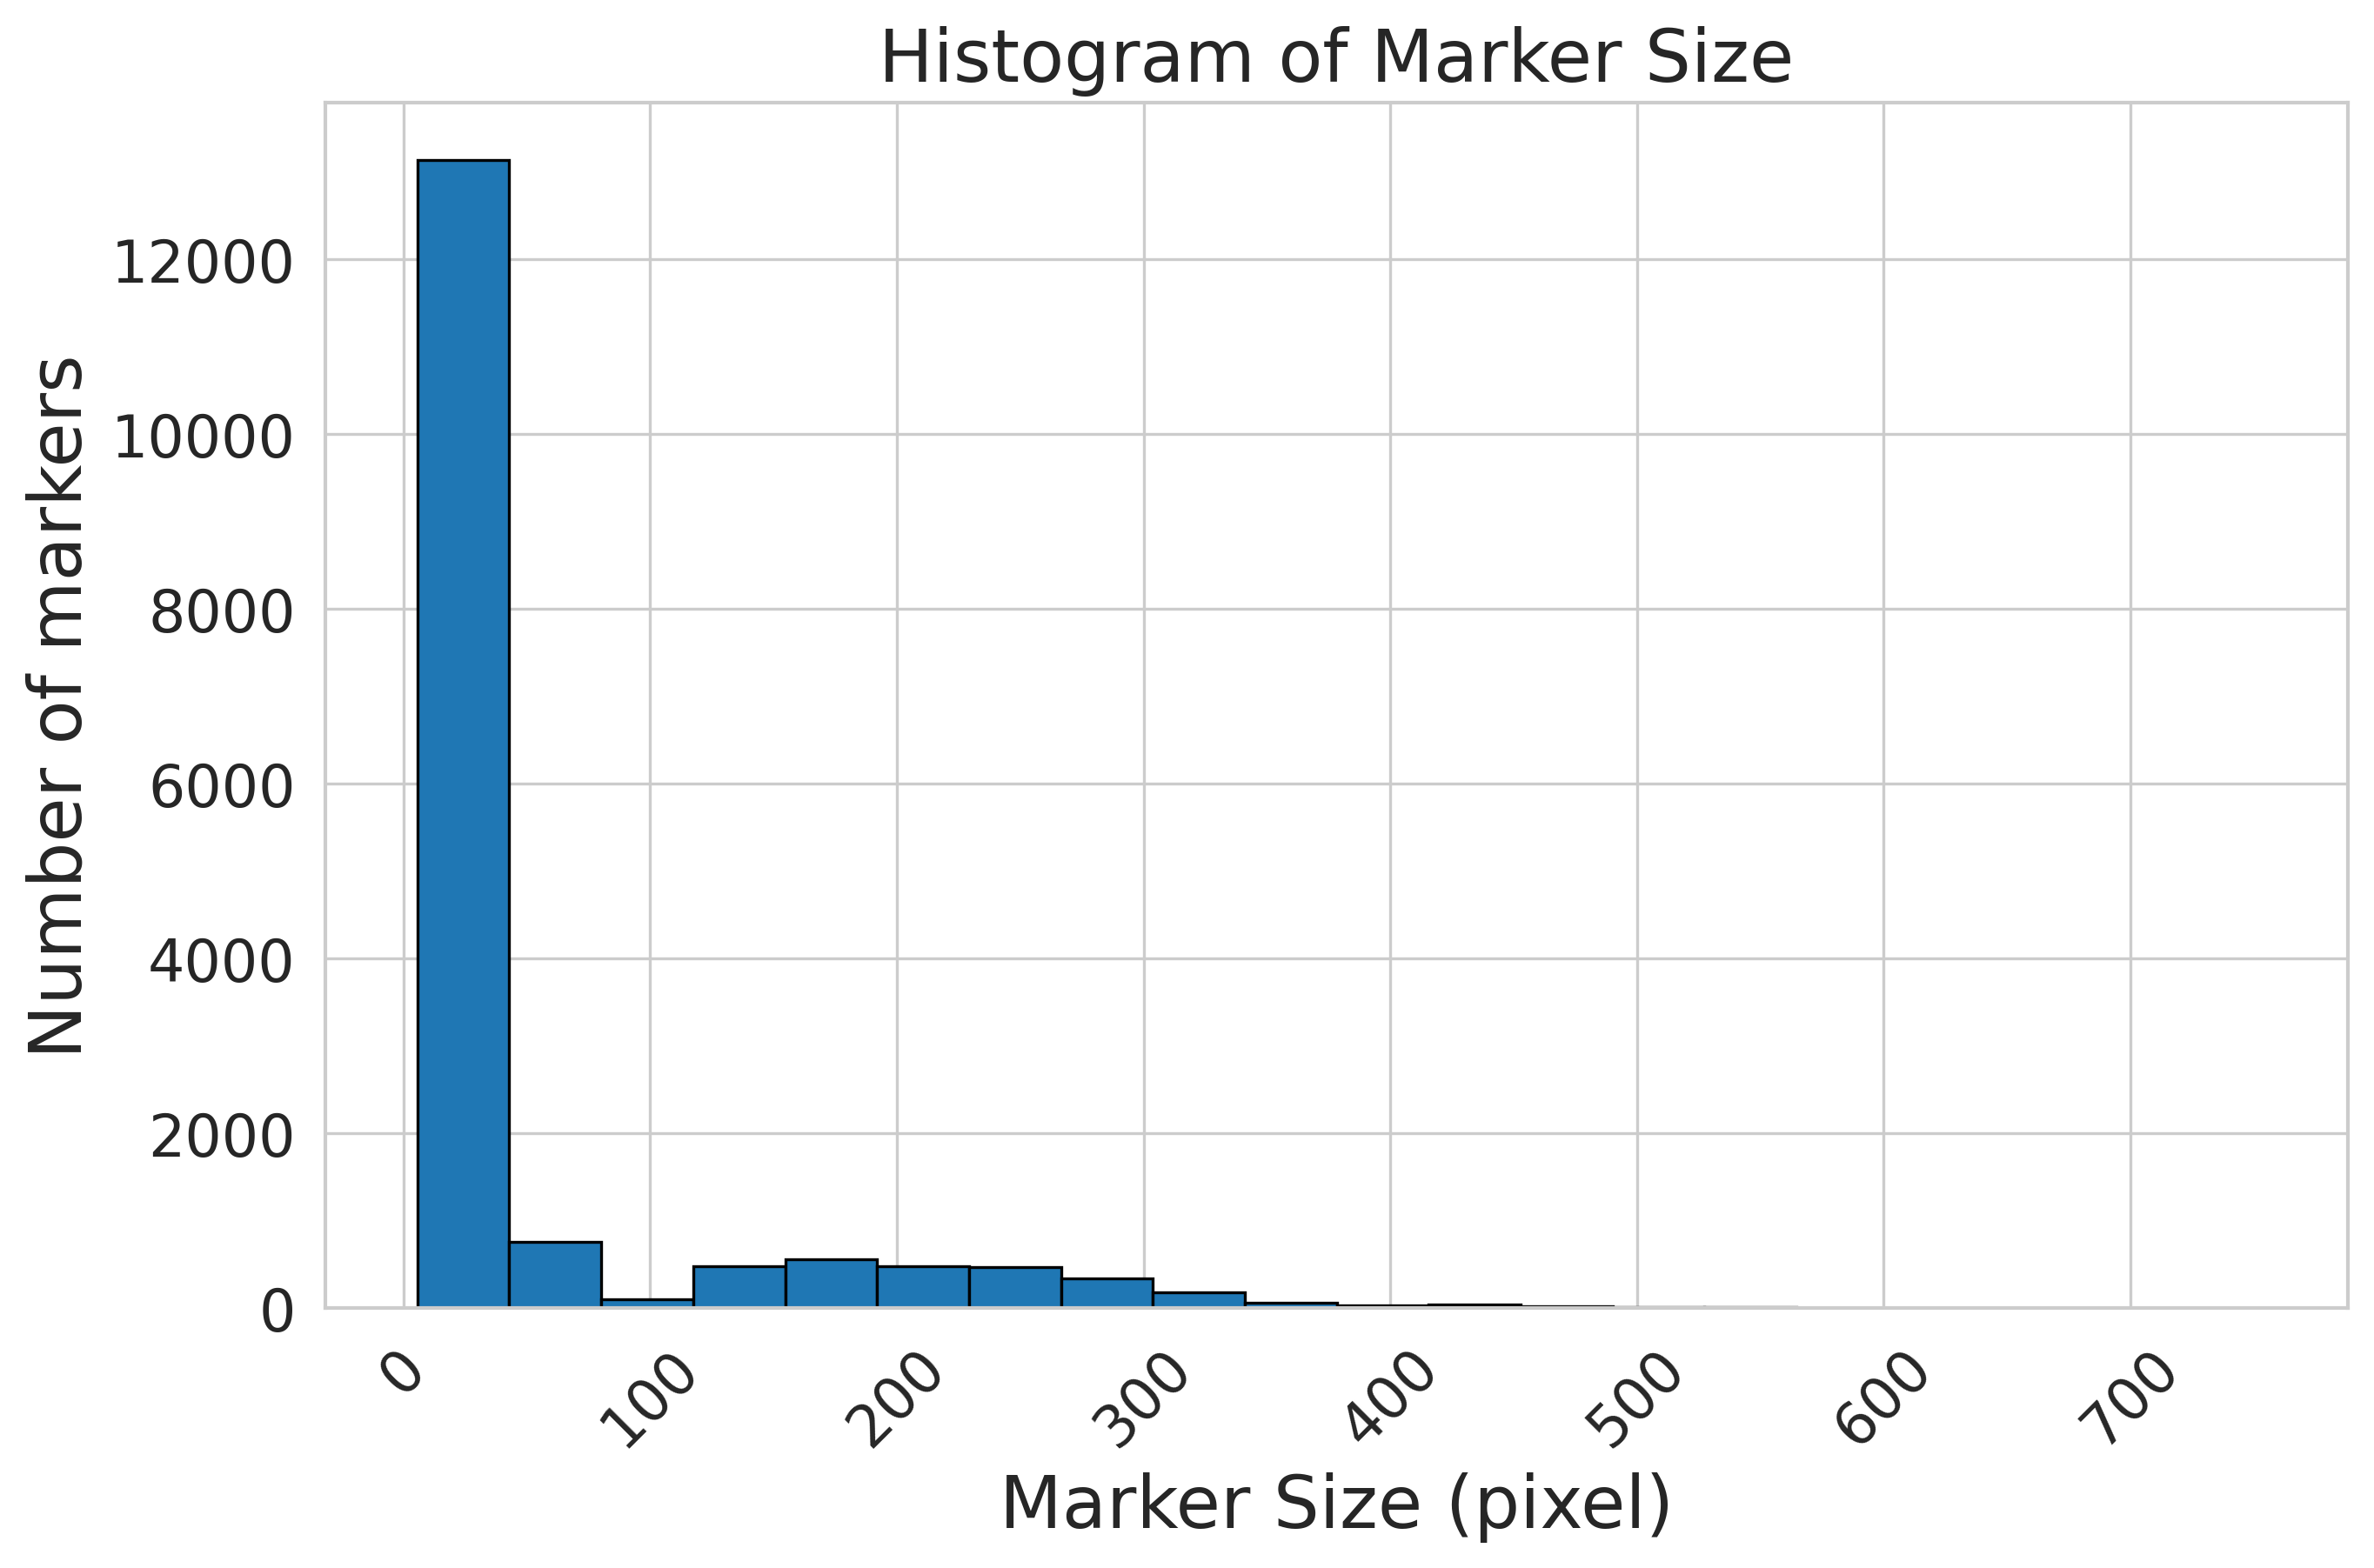

In [32]:
import matplotlib.pyplot as plt

# Filter out zeros from the 'marker_size' column
plt.figure(figsize=(10, 6), dpi=300)  # Higher DPI for better quality
filtered_data = dfm[dfm['marker_size'] != 0]['marker_size']

# Create the histogram
plt.hist(filtered_data, bins=20, edgecolor='black')
plt.xlabel('Marker Size (pixel)', fontsize=20)
plt.ylabel('Number of markers', fontsize=20)
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.title('Histogram of Marker Size', fontsize=20)
plt.show()